## Maximal Update Parameterization

In this problem, we will examine the training of a simple MLP with hidden layers of varying widths. We will then investigate the maximal update parameterization (muP) which will allow us to use a single global learning rate to jointly train layers of any width.

Note: This homework question is new this year and it is messier than usual. We felt it was worth it to get it out so you can play with these new techniques. If you're feeling stuck, don't hesistate to ask questions on Ed.


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import sys, os
# Import from the package path to avoid fragile sys.path hacks and to make
from src_sol.models import MLP
from src_sol.optimizers import SimpleAdam
from src_sol.training import train_one_step
# Optional: autoreload to pick up edits in the src package while the notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST data
(train_images, train_labels), (valid_images, valid_labels) = mnist.load_data()

# Normalize pixel values to [0, 1]
train_images = train_images.astype(np.float32) / 255.0
valid_images = valid_images.astype(np.float32) / 255.0

# Convert to PyTorch tensors
train_images = torch.from_numpy(train_images)
train_labels = torch.from_numpy(train_labels).long()
valid_images = torch.from_numpy(valid_images)
valid_labels = torch.from_numpy(valid_labels).long()

def rms(x, dim):
    return torch.sqrt(torch.mean(x**2, dim=dim))

def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')


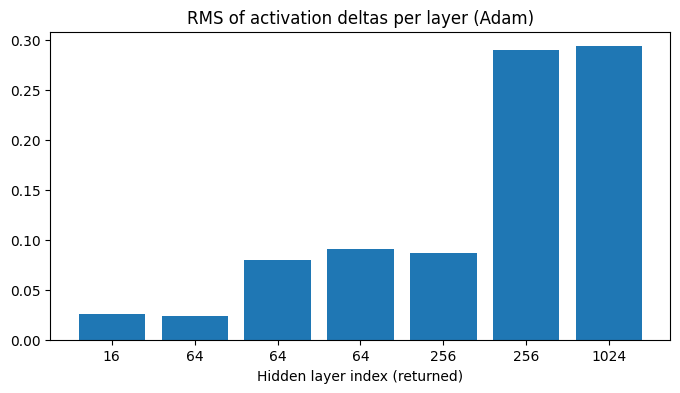

(8.523460388183594, 0.15625)

In [2]:
batch_idx = np.random.randint(0, len(train_images), size=64)

train_one_step(
    MLP,                                  # mlp
    [8, 16, 64, 64, 64, 256, 256, 1024],  # hiddens
    SimpleAdam,                           # optimizer
    "Adam",                               # label
    1e-2,                                 # lr
    train_images=train_images,
    train_labels=train_labels,
    batch_idx=batch_idx,
    device=device,
)

## a. Examining the norms of a heterogenous MLP.

Run the above cell, which trains a neural network for a single gradient step, then examines the effect of that step on the resulting activations. What are the dimensions of each layer in the neural network?

*Answer:* By default, there are 9 layers with the following layer dimensions: 
$$
(784 \times 8), \quad
(8 \times 16), \quad
(16 \times 64), \quad
(64 \times 64), \quad
(64 \times 64), \quad
(64 \times 256), \quad
(256 \times 256), \quad
(256 \times 1024), \quad
(1024 \times 10)
$$
Note that the above chart only plots activation deltas for the hidden layers, not the input or output layers.

How does the dimensionality of the layer affect the RMS norm of the activation deltas?

*Answer:* The RMS norm approximately scales with the input dimension of the layer. 

Change the widths of some of your neural network layers, and recreate the plot -- did the RMS values change as expected?

*Answer:* Yes, again we should see that the RMS values scale roughly with the input dimension of the layer.


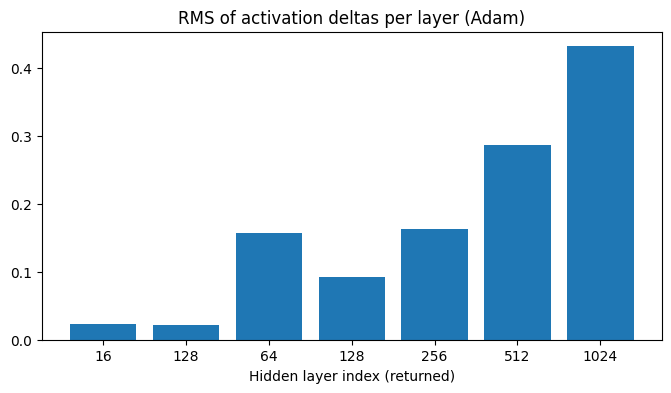

(5.515351295471191, 0.15625)

In [3]:
# TODO: Call some plotting code here.
train_one_step(
    MLP, 
    optimizer=SimpleAdam, 
    hiddens=[8, 16, 128, 64, 128, 256, 512, 1024], 
    train_images=train_images, 
    train_labels=train_labels, 
    batch_idx=batch_idx, 
    device=get_device()
    )

## b. Examining the norms of the updates to the weights.

In the provided code above, we plotted the change in norms of the *activation vectors*. Now, you will examine the change in the weights themselves. Create a version of the above function that runs a single gradient step, then for each dense layer plot:
- The *Frobenius* norm of the update.
- The *spectral* norm of the update.
- The *RMS-RMS induced norm* of the update.

Which one of these norms correlates the most with the RMS norms of the activations?

*Answer:* The induced RMS norm correlates the most with the RMS norms of the activations, as it scales with the input dimension of each layer.

You should calculate your updates as `new_dense_parameter - old_dense_parameter`.

TODO: Implement the norm computations in `src_sol/training.py` under the `training_one_step_matrices` function.

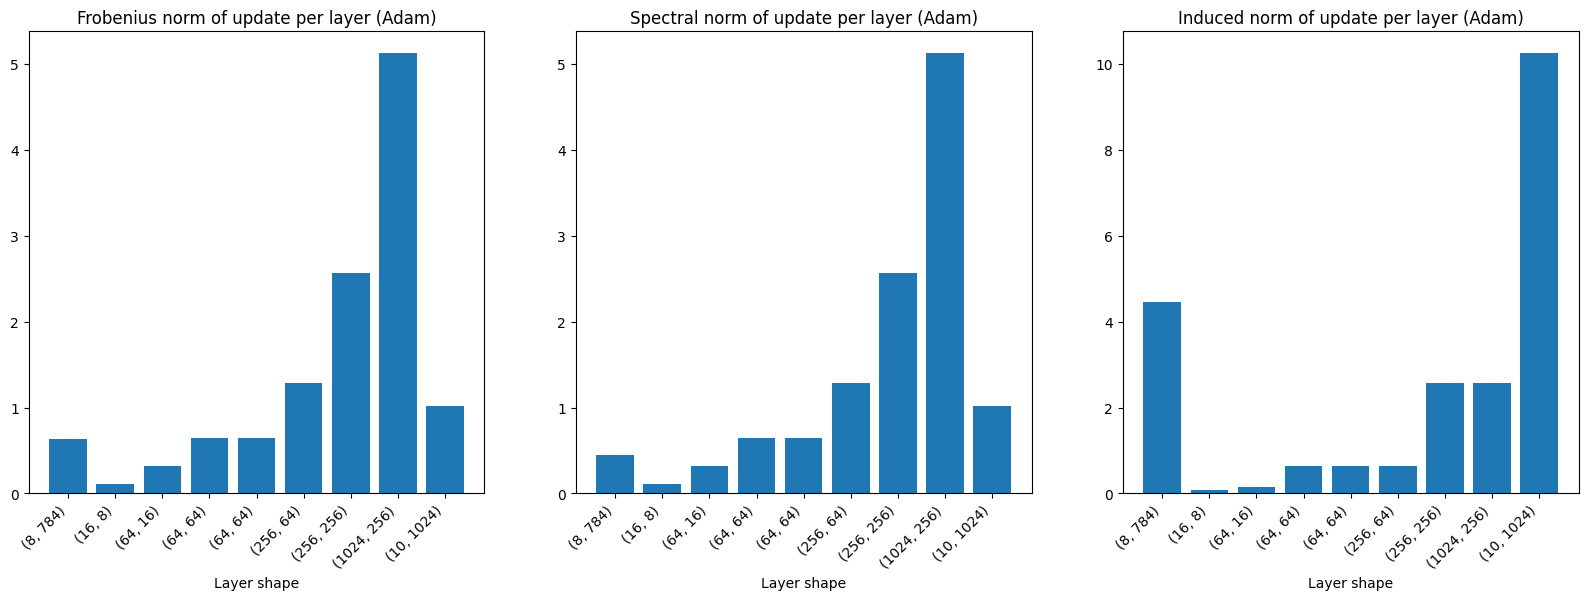

In [4]:
from src_sol.training import train_one_step_matrices

batch_idx = np.random.randint(0, len(train_images), size=64)

train_one_step_matrices(
    mlp=MLP,
    hiddens=[8, 16, 64, 64, 64, 256, 256, 1024],
    optimizer=SimpleAdam,
    lr=1e-2,
    train_images=train_images,
    train_labels=train_labels,
    batch_idx=batch_idx,
    device=device,
)

## c. Implementing muP

We will now implement muP scaling. Modify the starter code below to set a per-layer learning rate such that the resulting RMS activation-deltas are uniform scale, regardless of the layer widths. Plot the resulting activation-deltas on at least two sets of widths.

Note: Even with the correct scaling, the first 2-3 activation-deltas may have a lower norm than the rest. Can you think of a reason why this might be the case?

TODO: Implement the MuP scaling with Adam optimizers in `src_sol/optimizers.py` file under the `SimpleAdamMuP` class.

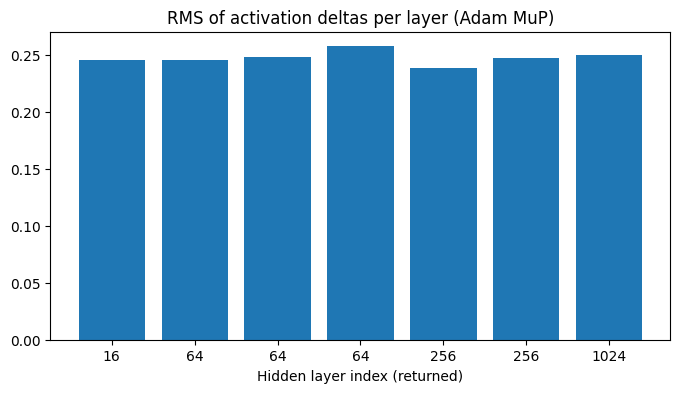

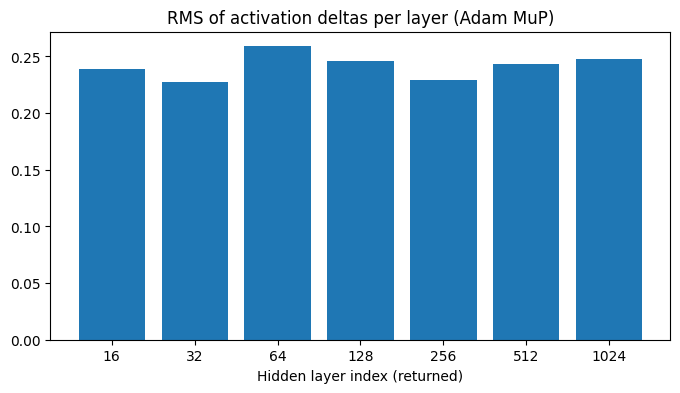

(3.362459659576416, 0.171875)

In [5]:
from src_sol.optimizers import SimpleAdamMuP

# First configuration
train_one_step(
    mlp=MLP,
    hiddens=[8, 16, 64, 64, 64, 256, 256, 1024],     # layer widths
    optimizer=SimpleAdamMuP,                         # optimizer class
    label="Adam MuP",                                # label for the plot
    lr=2,                                            # learning rate
    train_images=train_images,                       # training data
    train_labels=train_labels,
    device=get_device()                                   # device (CPU/GPU)
)

# Second configuration
train_one_step(
    mlp=MLP,
    hiddens=[8, 16, 32, 64, 128, 256, 512, 1024],
    optimizer=SimpleAdamMuP,
    label="Adam MuP",
    lr=2,
    train_images=train_images,
    train_labels=train_labels,
    device=get_device()
)


## d. Per-Weight Multipliers

An alternative way to implement muP is to adjust the *network graph* itself, rather than the optimizer. Implement this below, and recreate the above uniformly-scaled graph when using the *Adam* (not muP) optimizer. We have disabled biases to simplify the problem.

Why is multiplying the output of a layer by a constant the same as adjusting the learning-rate of that layer (when using Adam or SignGD)?

*Answer:* Adam is invariant to scalings of the gradients, so the update itself does not change when we scale the output of our layer. Therefore, dividing the activation by $d_{in}$ does not change the weight update itself, but scales down the update's effect on the activation (i.e. the activation delta) by a factor $d_{in}$. 

Note that scaling down the activation in this manner effectively scales down our weight initializations by a factor of $d_{in}$, so we must scale up our weight initializations to compensate and recover the correct muP initialization.

TODO: Implement the MuP scaling within the MLP in `src_sol/models.py` under the `ScaledMLP` class.


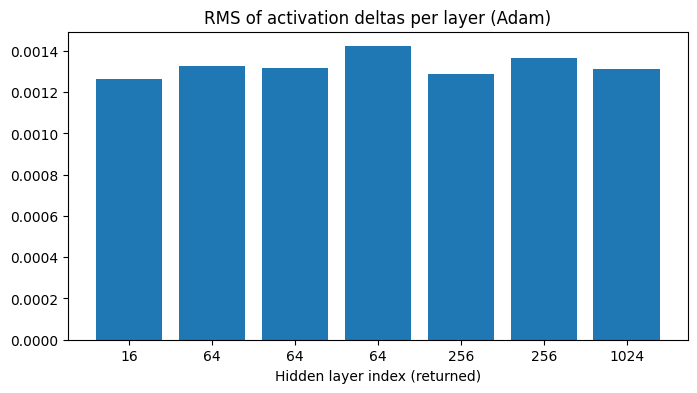

(307.7879638671875, 0.109375)

In [6]:
from src_sol.models import ScaledMLP

train_one_step(
    mlp=ScaledMLP,
    hiddens=[8, 16, 64, 64, 64, 256, 256, 1024],
    optimizer=SimpleAdam,
    label="Adam",
    lr=1e-2,
    train_images=train_images,
    train_labels=train_labels,
    batch_idx=batch_idx,
    device=get_device()
)

## e. Hyperparameter Transfer

Run the following code, which will perform a sweep over learning rates for 3-layer MLPs of increasing width using Adam. How does the optimal learning rate change as the network increases in size?

*Answer:* The optimal learning rate tends to decrease as the network width increases. This roughly matches our intuition that gradient norms increase with layer width, so we might need to decrease the learning rate to maintain stability during training.

In the second cell, we will instead use the muP optimizer you implemented. How does the optimal learning rate work now? You should aim to show that there is a single global learning rate that works on a majority of widths. The 256-width network should achieve a loss of 0.5, comparable to Adam.

*Answer:* Most networks achieve the best performance with a learning rate of 1.0. We also see that the 256-width network using the muP optimizer matches or exceeds the performance of the Adam optimizer.


In [7]:
valid_idx = np.random.randint(0, len(train_images), size=64)
valid_images = train_images[valid_idx]
valid_labels = train_labels[valid_idx]
valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)

C:\Users\Srikar\AppData\Local\Temp\ipykernel_11360\1470660870.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


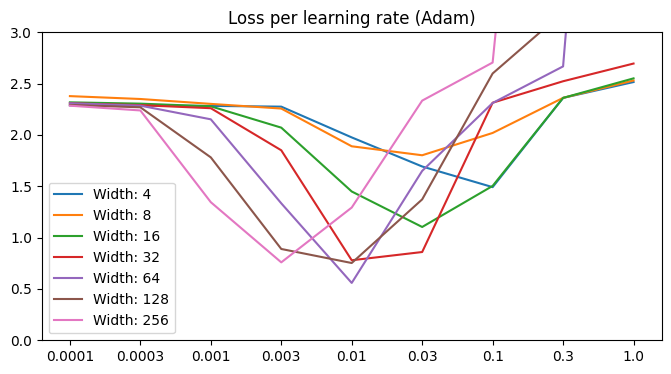

In [8]:
from src_sol.training import train_with_lr

all_widths = [4, 8, 16, 32, 64, 128, 256]
all_lrs = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
adam_results = np.zeros((len(all_widths), len(all_lrs)))
for wi, width in enumerate(all_widths):
    for lri, lr in enumerate(all_lrs):
        adam_results[wi, lri] = train_with_lr(
            mlp=MLP,
            hiddens=[width, width, width],
            optimizer=SimpleAdam,          # ← required
            lr=lr,
            train_images=train_images,
            train_labels=train_labels,
            valid_images=valid_images,
            valid_labels=valid_labels,
            device=get_device(),
            steps=100,
        )

fig, axs = plt.subplots(1, figsize=(8, 4))
axs.set_title(f'Loss per learning rate (Adam)')
for wi, width in enumerate(all_widths):
    axs.plot(np.arange(len(all_lrs)), adam_results[wi], label=f'Width: {width}')
axs.set_xticks(np.arange(len(all_lrs)))
axs.set_xticklabels(all_lrs)
axs.set_ylim(bottom=0, top=3)
axs.legend()
fig.show()

C:\Users\Srikar\AppData\Local\Temp\ipykernel_11360\3077334952.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


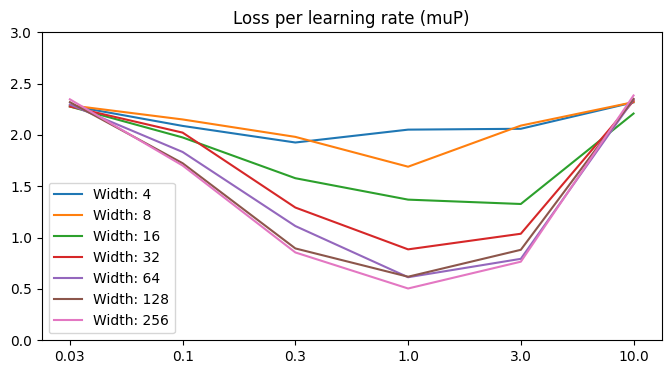

In [9]:
from src_sol.training import train_with_lr
from src_sol.optimizers import SimpleAdamMuP

all_widths = [4, 8, 16, 32, 64, 128, 256]
all_lrs = [0.03, 0.1, 0.3, 1.0, 3.0, 10.0]
adamMup_results = np.zeros((len(all_widths), len(all_lrs)))
for wi, width in enumerate(all_widths):
    for lri, lr in enumerate(all_lrs):
        adamMup_results[wi, lri] = train_with_lr(
            mlp=MLP,
            hiddens=[width, width, width],
            optimizer=SimpleAdamMuP,         # ← required
            lr=lr,
            train_images=train_images,
            train_labels=train_labels,
            valid_images=valid_images,
            valid_labels=valid_labels,
            device=get_device(),
            steps=100,
        )

fig, axs = plt.subplots(1, figsize=(8, 4))
axs.set_title(f'Loss per learning rate (muP)')
for wi, width in enumerate(all_widths):
    axs.plot(np.arange(len(all_lrs)), adamMup_results[wi], label=f'Width: {width}')
axs.set_xticks(np.arange(len(all_lrs)))
axs.set_xticklabels(all_lrs)
axs.set_ylim(bottom=0, top=3)
axs.legend()
fig.show()

## e. Shampoo and Orthogonalization

In lecture, we discussed a simplified version of the Shampoo update, which can be viewed as *orthogonalizing* the update to a dense layer. In the following code block, implement this simplified Shampoo update:

$$
momentum \rightarrow U \Sigma V^T. \qquad update = UV^T.
$$

Feel free to use linear algebra functions such as `torch.linalg.svd`.

Now, we will examine the relationship between the Frobenius norm and the Spectral norm for Adam vs. Shampoo. Plot these norms using your code from part c. What relationship do you see? Can you come up for a reason why this makes sense?

*Answer:* Note that the Shampoo update is always an orthogonal matrix. Therefore, the Frobenius norm of the Shampoo update is equal to the square root of its rank, which is the minimum its input and output dimension. Furthermore, the spectral norm of the Shampoo update is constant because all its singular values (and thus the spectral norm) are equal to 1. 

Bonus: How should we scale the Shampoo update so the *induced RMS-RMS norm* is equal? Implement this change.

*Answer:* As we've seen, Shampoo ensures keeps the spectral norm of the update constant across layers. Furthermore, the induced RMS-RMS norm is equal to the spectral norm multiplied by $\sqrt{d_{in}/d_{out}}$. Therefore, scaling our update by $\sqrt{d_{out}/d_{in}}$ (the reciprocal of this scaling) ensures that the induced RMS-RMS norm, rather than the spectral norm, is constant across layers.

TODO: Implement the Shampoo and Scaled Shampoo optimizers in `src_sol/optimizers.py` under the `SimpleShampoo` and `SimpleShampooScaled` classes respectively.

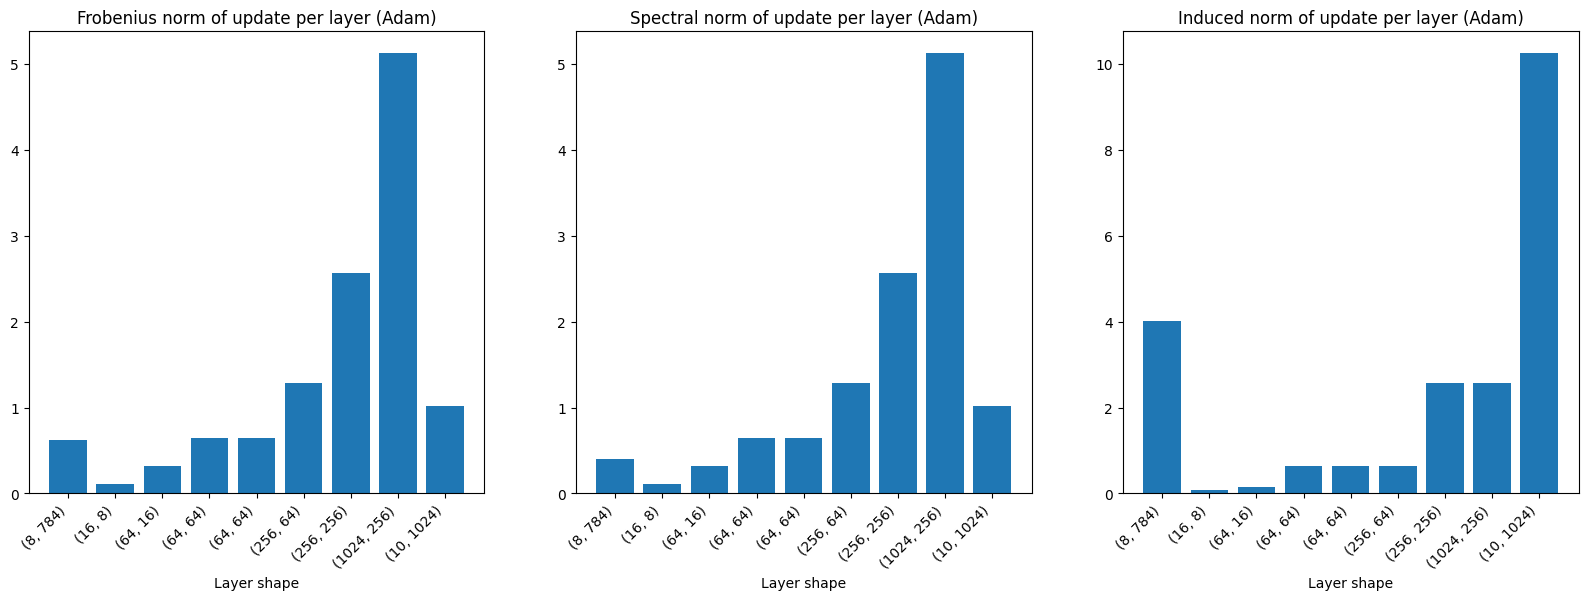

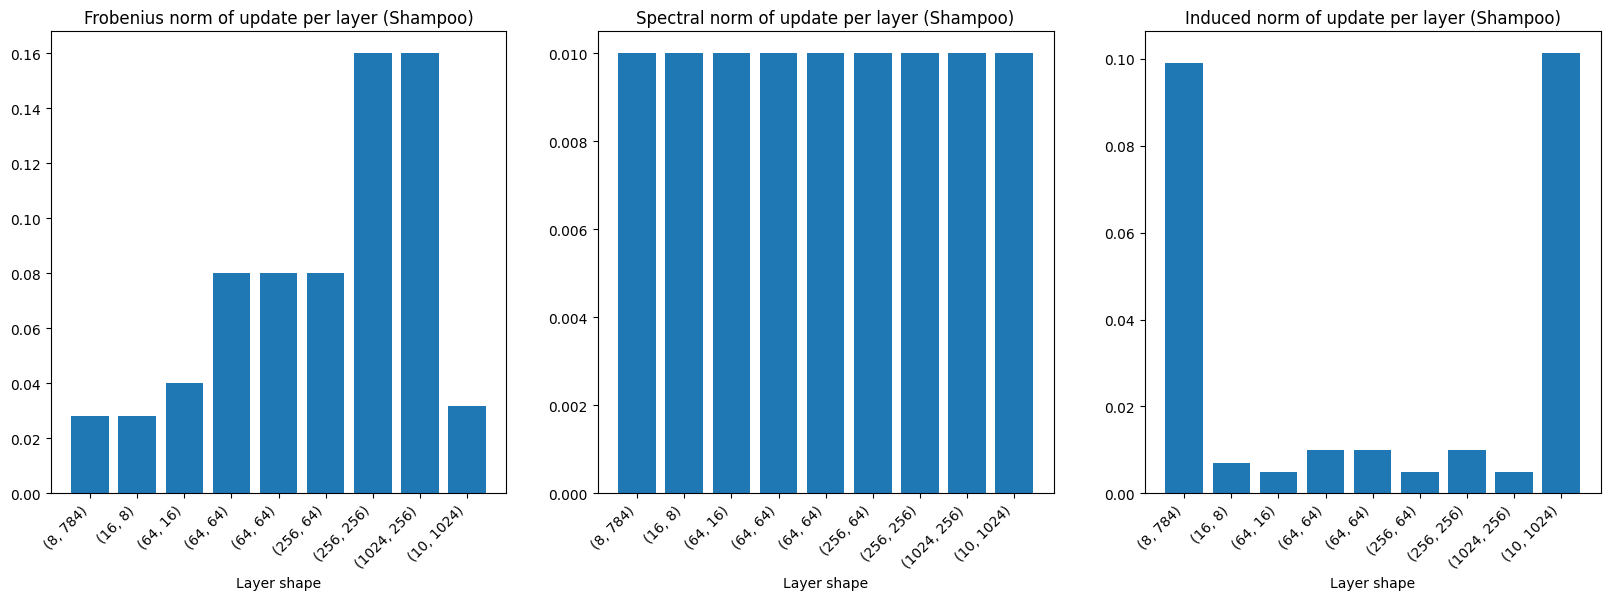

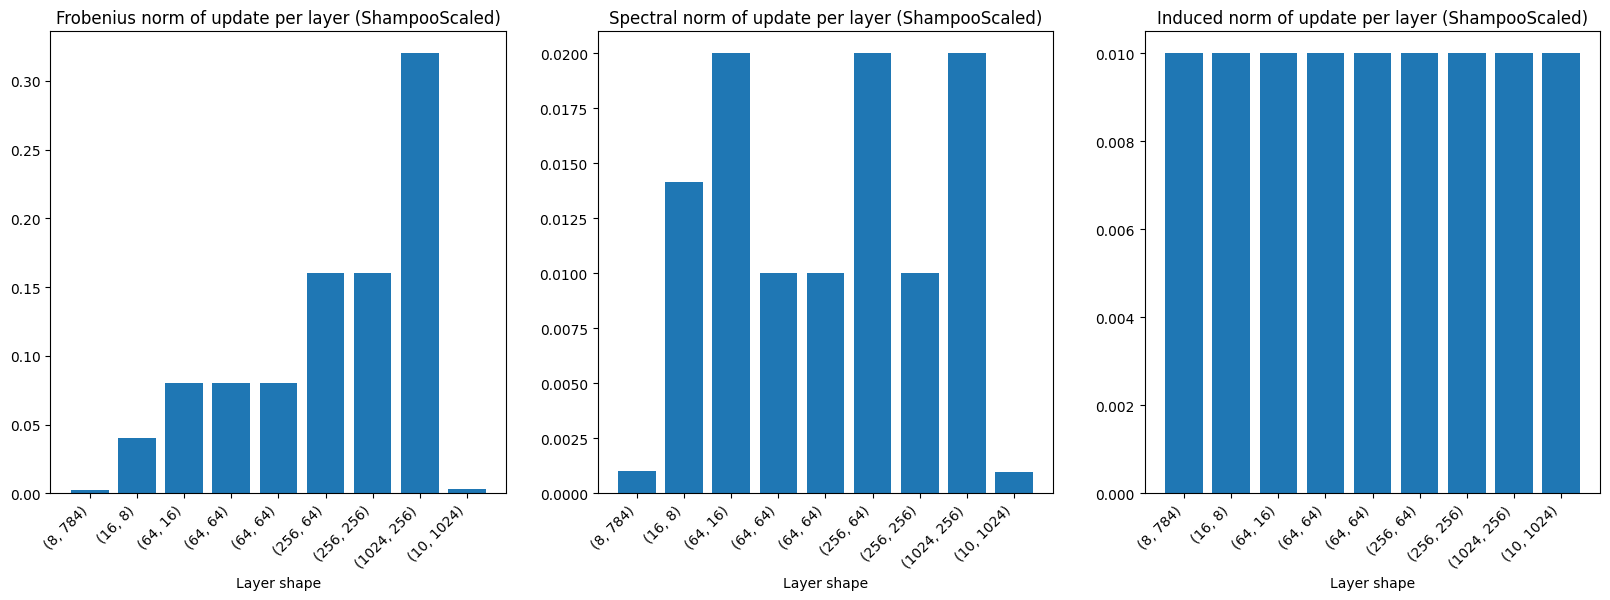

In [10]:
from src_sol.optimizers import SimpleShampoo, SimpleShampooScaled

batch_idx = np.random.randint(0, len(train_images), size=64)

train_one_step_matrices(mlp=MLP, optimizer=SimpleAdam, label="Adam", train_images=train_images, train_labels=train_labels, batch_idx=batch_idx, device=device)
train_one_step_matrices(mlp=MLP, optimizer=SimpleShampoo, label="Shampoo", train_images=train_images, train_labels=train_labels, batch_idx=batch_idx, device=device)
train_one_step_matrices(mlp=MLP, optimizer=SimpleShampooScaled, label="ShampooScaled", train_images=train_images, train_labels=train_labels, batch_idx=batch_idx, device=device)